In [1]:
import numpy as np
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as f
import torch.optim as optim
import torchvision
from torchvision.transforms import v2
import random
from PIL import Image
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

In [2]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr


In [3]:
dataset_path = "/kaggle/input/image-super-resolution/dataset"
train= dataset_path+"/train/"
val = dataset_path+ "/val/"
train_hires= train+ "high_res/"
train_lowres= train + "low_res/"

In [4]:
hiresimgs= os.listdir(train_hires)
lowresimgs= os.listdir(train_lowres)

len(hiresimgs), len(lowresimgs)

(685, 685)

(256, 256, 4) (256, 256, 4)


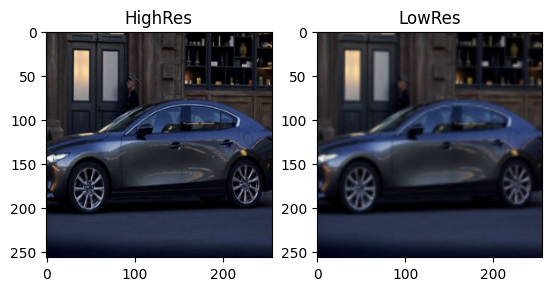

(256, 256, 4) (256, 256, 4)


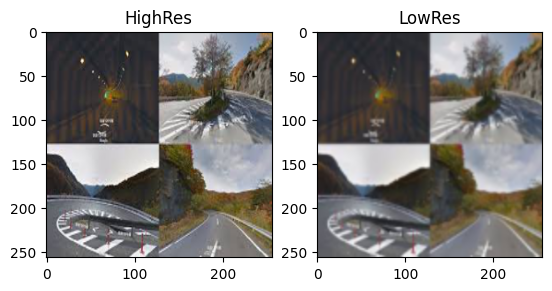

In [5]:
for i in range(2):
    hipath= train_hires+ hiresimgs[i]
    lowpath= train_lowres+ lowresimgs[i]
    
    hi= np.array(Image.open(hipath))
    lo= np.array(Image.open(lowpath))
    
    print(hi.shape, lo.shape)
    ax= plt.subplot(121)
    ax.imshow(hi)
    ax.set_title("HighRes")

    ax1= plt.subplot(122)
    ax1.imshow(lo)
    ax1.set_title("LowRes")

    plt.show()

In [6]:
def calculate_psnr(sr_img, hr_img):
    """Calculates PSNR between the super-resolution (SR) image and the high-resolution (HR) image."""
    psnr_value = psnr(hr_img, sr_img, data_range=hr_img.max() - hr_img.min())
    return psnr_value

def calculate_ssim(sr_img, hr_img):
    """Calculates SSIM between the super-resolution (SR) image and the high-resolution (HR) image."""
    ssim_value = ssim(hr_img, sr_img, multichannel=True, data_range=hr_img.max() - hr_img.min())
    return ssim_value


In [7]:
hi.shape == (256, 256, 4) 

True

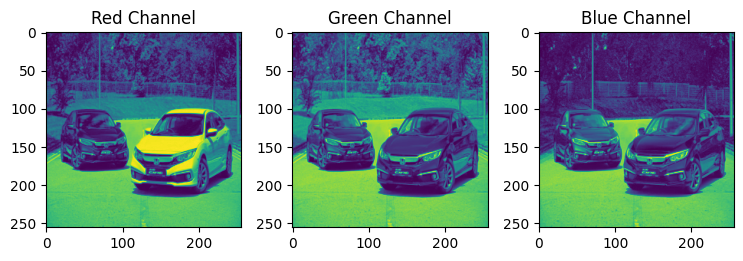

In [8]:
import matplotlib.pyplot as plt
from PIL import Image
image_path = "/kaggle/input/image-super-resolution/dataset/train/high_res/0.png"  
image = Image.open(image_path).convert("RGB")
r, g, b = image.split()


plt.figure(figsize=(10, 5))
plt.subplot(1, 4, 1)
plt.imshow(r)
plt.title('Red Channel')

plt.subplot(1, 4, 2)
plt.imshow(g)
plt.title('Green Channel')

plt.subplot(1, 4, 3)
plt.imshow(b)
plt.title('Blue Channel')

plt.tight_layout()
plt.show()


In [9]:
for i in range(len(train_hires)):
    
    hipath= train_hires+ hiresimgs[i]
    lowpath= train_lowres+ lowresimgs[i]
    
    hi= np.array(Image.open(hipath))
    lo= np.array(Image.open(lowpath))
    
    x,y=hi.shape,lo.shape 
    if x!=(256, 256, 4) or y!=(256, 256, 4):
        print(hipath, x.shape, lopath, y.shape)
    

In [10]:
class SRDataset(Dataset):
    def __init__(self, dataset_dir,mode="train", transforms=None):
        
        self.train = dataset_dir + f"/{mode}/"
        
        self.train_hires= self.train+ "high_res/"
        self.train_lowres= self.train + "low_res/"
                                      
        self.hiimgs = sorted(os.listdir(self.train_hires))
        self.lowimgs= sorted(os.listdir(self.train_lowres))
                                      
        self.tf= transforms

    def __len__(self):
        return len(self.hiimgs)

    def __getitem__(self, idx):
    
        hiresimg= Image.open(self.train_hires+ self.hiimgs[idx]).convert("RGB")
        lowresimg= Image.open(self.train_lowres+ self.lowimgs[idx]).convert("RGB")
        
        state = torch.get_rng_state()
        hiresimg=self.tf(hiresimg)
        torch.set_rng_state(state)
        lowresimg= self.tf(lowresimg)
        
        return lowresimg, hiresimg


In [11]:
transformations = v2.Compose([
    v2.RandomHorizontalFlip(p=0.7),
    v2.RandomVerticalFlip(p=0.7),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
        ])

In [12]:
test_transformations= v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
        ])

In [13]:
train_dataset = SRDataset(dataset_path, "train", transformations)
test_dataset= SRDataset(dataset_path, 'val',test_transformations)

In [14]:
len(train_dataset), len(test_dataset)

(685, 170)

In [15]:
batch_size = 16
dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,drop_last= True)
test_dataloader= DataLoader(test_dataset, batch_size= batch_size, shuffle=True)

In [16]:
len(dataloader)

42

In [17]:
low,hi= next(iter(dataloader))

low.shape, hi.shape

(torch.Size([16, 3, 256, 256]), torch.Size([16, 3, 256, 256]))

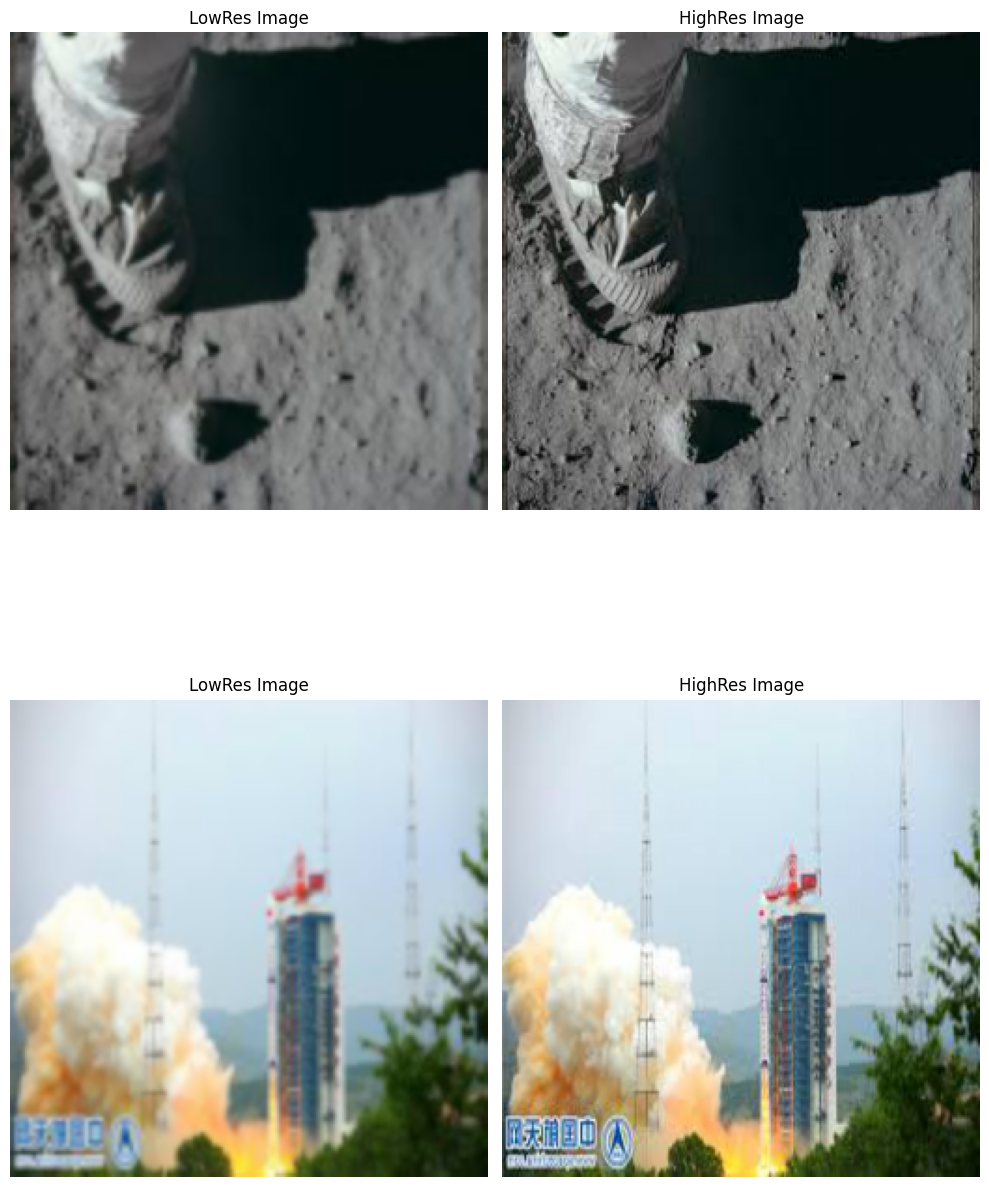

In [20]:
num_images_to_plot = 2
fig, axes = plt.subplots(num_images_to_plot, 2, figsize=(10, 15))

for i, (lowres, highres) in enumerate(dataloader):
    for j in range(num_images_to_plot):
        lo = lowres[j].permute(1, 2, 0).numpy()
        hi = highres[j].permute(1, 2, 0).numpy()
        
        # Plot noisy image
        axes[j, 0].imshow(lo)
        axes[j, 0].set_title('LowRes Image')
        axes[j, 0].axis('off')
        
        # Plot original image (target)
        axes[j, 1].imshow(hi)
        axes[j, 1].set_title('HighRes Image')
        axes[j, 1].axis('off')
        
    break  # Stop after first batch for demonstration

plt.tight_layout()
# plt.Arrowshow()

In [21]:
class DoubleConv(nn.Module):
    
    def __init__(self, in_channels,out_channels):
        
        super().__init__()
        
        self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1), #we're preserving input height and width
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        
        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1), #we're preserving input height and width
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
        )
    
    def forward(self,x):
        return self.conv(x)

In [28]:
class UNET(nn.Module):
    
    def __init__(self, in_channels=3, out_channels=3, features=[64,128,256,512,1024]):
        
        super().__init__()
        
        self.downsamples=nn.ModuleList()
        
        self.upsamples= nn.ModuleList()
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        #now building the encoder
        
        for feature in features:
            self.downsamples.append(DoubleConv(in_channels, feature))
            in_channels=feature

        #the decoder
        
        for feature in reversed(features):
            self.upsamples.append(
                nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)
            )
            self.upsamples.append(DoubleConv(feature*2, feature))
            
        #bottleneck layer
        self.bottleneck= DoubleConv(features[-1], features[-1]*2)

        #final 1x1 conv to change out_channels
        self.final= nn.Conv2d(features[0], out_channels, kernel_size=1)
        
        
    def forward(self,x):
        skip_connections=[]

        for downsampler in self.downsamples:

            x = downsampler(x) #this is the output of each downsampling layer
            skip_connections.append(x)
            x= self.pool(x)

        x= self.bottleneck(x) 

        skip_connections= skip_connections[::-1]

        for i in range(0, len(self.upsamples), 2):

            x= self.upsamples[i](x) # this is the conv transpose layer
            skipped= skip_connections[i//2]

            concat_skipped= torch.cat((skipped,x),dim=1)

            x=self.upsamples[i+1](concat_skipped) #this is the double conv layer

        return self.final(x)

In [29]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [30]:
torch.manual_seed(42)

model = UNET().to(device)

x = torch.randn(1, 3, 256, 256).to(device)
    
output = model(x)

print("Final output size:", output.size())

Final output size: torch.Size([1, 3, 256, 256])


In [31]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
pytorch_total_params

124386371

## VGG Loss

In [32]:
import torch
import torchvision.models as models
model_path = '/kaggle/input/vgg/pytorch/default/1/vgg16-397923af.pth' 
vgg = models.vgg16()
vgg.load_state_dict(torch.load(model_path,weights_only=True))

<All keys matched successfully>

In [33]:
class VGGPerceptualLoss(nn.Module):


    
    def __init__(self, feature_extractor, diction, criterion, lambdas):
        super(VGGPerceptualLoss, self).__init__()
        self.feature_extractor = feature_extractor
        self.diction = diction
        self.criterion = criterion
        self.lambdas = lambdas

    def forward(self, x, y):
        x_features = self.feature_extractor(x,self.diction)
        y_features = self.feature_extractor(y,self.diction)
#         print(len(x_features), len(y_features))
        loss = 0
        for layer_name,_ in self.diction.items():
            x_feat = x_features[layer_name]
            y_feat = y_features[layer_name]
            
            loss += self.lambdas[layer_name] * self.criterion(x_feat, y_feat)        
        return loss


In [34]:
features = list(vgg.features.children())[:28]
features = nn.Sequential(*features)
layers = {'6':'6','15':'15','27':'27'}
vgg_feature_extractor = {'6': features[:7].to(device), '15': features[7:16].to(device), '27': features[16:].to(device)}
lambdas = {'6': 0.3, '15': 0.3, '27': 0.4}
features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [35]:
def feature_extractor(x, dic):
    
    features = {}
    for name, sequence in dic.items():
        x= sequence(x)
        features[name] = x
    
    return features   

In [36]:
criterion_mse = nn.MSELoss()

vgg_tester= VGGPerceptualLoss(feature_extractor, vgg_feature_extractor, criterion_mse,lambdas)

In [37]:
rand1 = torch.rand(8, 3, 256, 256).to(device)
rand2= torch.rand(8,3,256,256).to(device)

In [38]:
vgg_loss= vgg_tester.forward(highres[0].to(device), highres[0].to(device))
print(type(vgg_loss), vgg_loss)

<class 'torch.Tensor'> tensor(0., grad_fn=<AddBackward0>)


## Training Loop

In [39]:
criterion = nn.MSELoss() #
criterion_vgg = VGGPerceptualLoss(feature_extractor, vgg_feature_extractor, criterion_mse,lambdas).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0002)

In [40]:
from skimage.metrics import structural_similarity as ssim

# Your function to calculate SSIM with win_size adjustment
def calculate_ssim(sr_img, hr_img):
    # Ensure win_size is less than or equal to the smallest side of the image
    win_size = min(sr_img.shape[0], sr_img.shape[1], 7)  # Example: win_size = 7 if images are >= 7x7
    return ssim(sr_img, hr_img, win_size=win_size, multichannel=True)


In [41]:
def calculate_ssim(sr_img, hr_img):
    # Find the smallest dimension of the image
    min_side = min(sr_img.shape[0], sr_img.shape[1])
    
    # Ensure win_size is an odd number and less than or equal to min_side
    win_size = min(min_side, 7)  # Choose the smaller value between min_side and 7
    if win_size % 2 == 0:  # Ensure win_size is odd
        win_size -= 1
    
    # Calculate SSIM, setting channel_axis for RGB images and data_range for floating point images
    return ssim(sr_img, hr_img, win_size=win_size, channel_axis=-1, data_range=1.0)


In [42]:
def validate(model, dataloader, criterion, device):
    """Function to validate the model on validation dataset and return the loss."""
    model.eval()  # Set model to evaluation mode
    total_loss = 0.0
    with torch.no_grad():  # Disable gradient computation
        for lowres, highres in dataloader:
            outputs = model(lowres.to(device))
            loss = criterion(outputs, highres.to(device))
            total_loss += loss.item()
    
    return total_loss / len(dataloader)  # Average loss

In [43]:
import time
import torch
import psutil  # For checking memory usage on CPU
from torchinfo import summary  # Tool for computing FLOPs and parameters


In [44]:

# Track training time, PSNR, SSIM, memory, and complexity (FLOPs & parameters)
num_epochs = 14
train_losses = []
val_losses = []
psnr_history = []
ssim_history = []

start_time = time.time()  # Start time for total training time

for epoch in range(num_epochs):
    epoch_start_time = time.time()  # Start time for each epoch
    running_loss = 0.0
    total_psnr = 0.0
    total_ssim = 0.0
    
    print(f"Epoch [{epoch+1}]")
    
    for i, (lowres, highres) in enumerate(dataloader):
        optimizer.zero_grad()
        
        # Forward pass: Generate SR images
        outputs = model(lowres.to(device))
        
        # Calculate loss (MSE + VGG loss)
        loss = 4 * criterion(outputs, highres.to(device))  # MSE Loss
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        # Convert SR and HR images to numpy for PSNR/SSIM calculation
        sr_img = outputs.cpu().detach().numpy().transpose(0, 2, 3, 1)  # Shape: (batch, H, W, C)
        hr_img = highres.cpu().detach().numpy().transpose(0, 2, 3, 1)  # Shape: (batch, H, W, C)

        # Compute PSNR and SSIM for each image in the batch
        batch_psnr = 0
        batch_ssim = 0
        for j in range(sr_img.shape[0]):
            batch_psnr += calculate_psnr(sr_img[j], hr_img[j])
            batch_ssim += calculate_ssim(sr_img[j], hr_img[j])

        total_psnr += batch_psnr / sr_img.shape[0]
        total_ssim += batch_ssim / sr_img.shape[0]

    # Calculate average training loss and metrics
    avg_train_loss = running_loss / len(dataloader)
    avg_psnr = total_psnr / len(dataloader)
    avg_ssim = total_ssim / len(dataloader)
    
    train_losses.append(avg_train_loss)
    psnr_history.append(avg_psnr)
    ssim_history.append(avg_ssim)
    
    # Validate the model after each epoch
    val_loss = validate(model, test_dataloader, criterion, device)
    val_losses.append(val_loss)

    # Print average PSNR and SSIM
    epoch_time = time.time() - epoch_start_time  # Time per epoch
    print(f"Epoch [{epoch+1}] completed in {epoch_time:.2f}s with Avg PSNR: {avg_psnr:.3f}, Avg SSIM: {avg_ssim:.3f}, Val Loss: {val_loss:.6f}")
    
    # Memory usage (on GPU or CPU)
    if torch.cuda.is_available():
        print(f"GPU Memory Allocated: {torch.cuda.memory_allocated() / 1024 ** 2:.2f} MB")
    else:
        process = psutil.Process()
        memory = process.memory_info().rss / 1024 ** 2  # in MB
        print(f"CPU Memory Usage: {memory:.2f} MB")

# Total training time
total_time = time.time() - start_time
print(f"Total training time: {total_time / 60:.2f} minutes")




Epoch [1]
Epoch [1] completed in 3030.78s with Avg PSNR: 9.005, Avg SSIM: 0.168, Val Loss: 0.071640
CPU Memory Usage: 5369.78 MB
Epoch [2]
Epoch [2] completed in 2937.74s with Avg PSNR: 21.449, Avg SSIM: 0.644, Val Loss: 0.004595
CPU Memory Usage: 5267.91 MB
Epoch [3]
Epoch [3] completed in 2940.75s with Avg PSNR: 24.983, Avg SSIM: 0.784, Val Loss: 0.003125
CPU Memory Usage: 5355.77 MB
Epoch [4]
Epoch [4] completed in 2914.15s with Avg PSNR: 26.210, Avg SSIM: 0.820, Val Loss: 0.002644
CPU Memory Usage: 5283.88 MB
Epoch [5]
Epoch [5] completed in 2912.70s with Avg PSNR: 26.943, Avg SSIM: 0.838, Val Loss: 0.002289
CPU Memory Usage: 5303.92 MB
Epoch [6]
Epoch [6] completed in 2925.88s with Avg PSNR: 27.501, Avg SSIM: 0.852, Val Loss: 0.002077
CPU Memory Usage: 5319.85 MB
Epoch [7]
Epoch [7] completed in 3007.84s with Avg PSNR: 27.919, Avg SSIM: 0.863, Val Loss: 0.001917
CPU Memory Usage: 5283.93 MB
Epoch [8]
Epoch [8] completed in 2994.02s with Avg PSNR: 28.237, Avg SSIM: 0.871, Val Loss:

In [45]:
model.eval()

UNET(
  (downsamples): ModuleList(
    (0): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): DoubleConv(
  

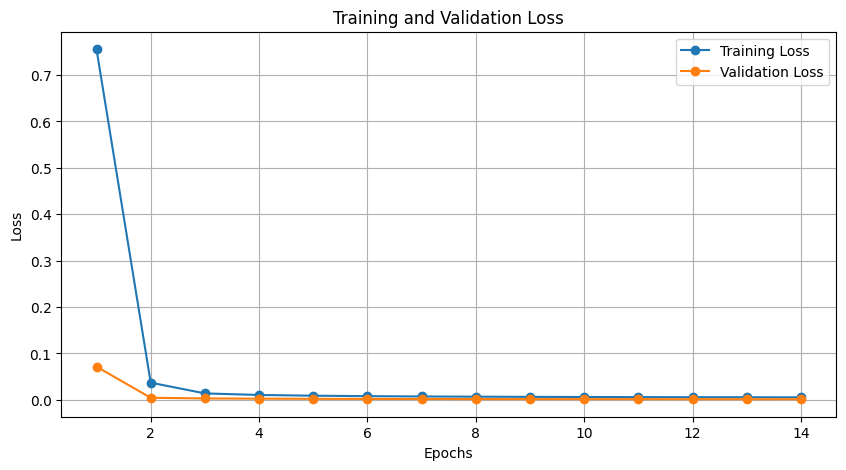

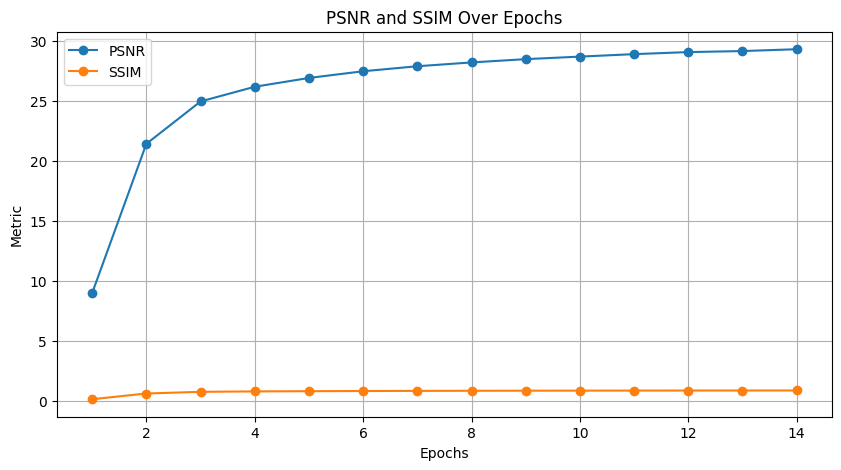

In [46]:


# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss VGG16')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


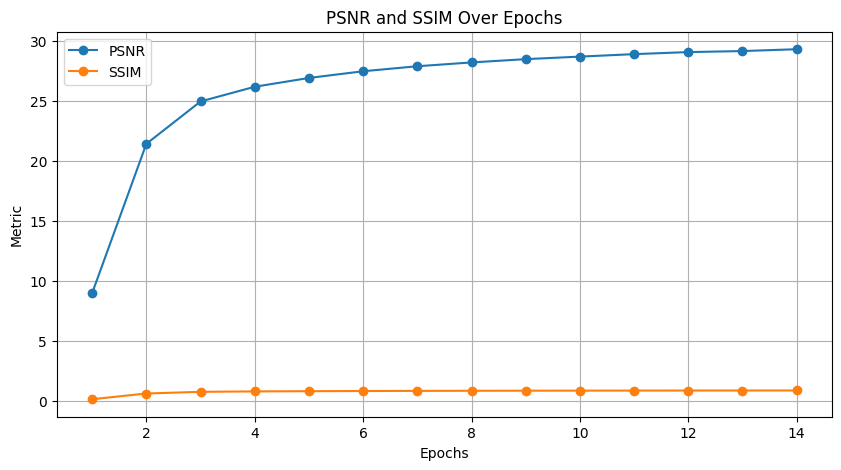

In [47]:

# Plot PSNR and SSIM over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), psnr_history, label='PSNR', marker='o')
plt.plot(range(1, num_epochs + 1), ssim_history, label='SSIM', marker='o')
plt.title('PSNR and SSIM Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Metric')
plt.legend()
plt.grid()
plt.show()

In [ ]:
batch = next(iter(dataloader))

In [ ]:

# Get a batch of data from the train set
batch = next(iter(dataloader))

# Extract noisy images from the batch
lowres = batch[0][:5].to(device)  # Select the first 5 images in the batch
highres = batch[1][:5].to(device)  # Corresponding original images

# Generate denoised images using the model
with torch.no_grad():
    srimages = model(lowres)
    srimages = srimages.view(-1, 3, 256, 256)  # Reshape to match the original image size

# Convert torch tensors to numpy arrays
lowres = lowres.cpu().numpy()
highres = highres.cpu().numpy()
srimages = srimages.cpu().numpy()

# Plot the images
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 9))

for i in range(5):
    # Plot noisy images
    axes[0, i].imshow(np.transpose(lowres[i], (1, 2, 0)))
    axes[0, i].set_title('LowRes Image')
    axes[0, i].axis('off')
    
    # Plot original images
    axes[1, i].imshow(np.transpose(highres[i], (1, 2, 0)))
    axes[1, i].set_title('HiRes Image')
    axes[1, i].axis('off')
    
    # Plot denoised images
    axes[2, i].imshow(np.transpose(srimages[i], (1, 2, 0)))
    axes[2, i].set_title('SR Image')
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
with torch.no_grad():
    total_psnr = 0.0
    total_ssim = 0.0
    for i, (lowres, highres) in enumerate(test_dataloader):
        outputs = model(lowres.to(device))
        
        sr_img = outputs.cpu().detach().numpy().transpose(0, 2, 3, 1)
        hr_img = highres.cpu().detach().numpy().transpose(0, 2, 3, 1)
        
        batch_psnr = 0
        batch_ssim = 0
        for j in range(sr_img.shape[0]):
            batch_psnr += calculate_psnr(sr_img[j], hr_img[j])
            batch_ssim += calculate_ssim(sr_img[j], hr_img[j])
        
        total_psnr += batch_psnr / sr_img.shape[0]
        total_ssim += batch_ssim / sr_img.shape[0]
    
    avg_psnr = total_psnr / len(test_dataloader)
    avg_ssim = total_ssim / len(test_dataloader)
    print(f"Test Set Evaluation - Avg PSNR: {avg_psnr:.3f}, Avg SSIM: {avg_ssim:.3f}")


In [ ]:
#saving model weights
weights_dir = "/kaggle/working/"
model_weights_path = os.path.join(weights_dir, 'UNET16VGG.pth')
torch.save(model.state_dict(), model_weights_path)


In [ ]:
from IPython.display import FileLink, FileLinks

In [ ]:
FileLinks('/kaggle/working') #lists all downloadable files on server

In [ ]:
num_images_to_plot = 10
fig, axes = plt.subplots(num_images_to_plot, 3, figsize=(12, 24))

lowres, highres = next(iter((test_dataloader)))

lowres = lowres.to(device)
outputs = model(lowres)
for j in range(num_images_to_plot):


    lo = lowres[j].cpu().detach().permute(1, 2, 0).numpy()
    output= outputs[j].cpu().detach().permute(1,2,0).numpy()
    hi = highres[j].permute(1, 2, 0).numpy()

    # Plot noisy image
    axes[j, 0].imshow(lo)
    axes[j, 0].set_title('LowRes Image')
    axes[j, 0].axis('off')

    # Plot original image (target)
    axes[j, 1].imshow(output)
    axes[j, 1].set_title('SR Image')
    axes[j, 1].axis('off')

    axes[j, 2].imshow(hi)
    axes[j, 2].set_title('HighRes Image')
    axes[j, 2].axis('off')
    

# break  # Stop after first batch for demonstration

plt.tight_layout()
# plt.Arrowshow()